# House Prices Regression Analysis


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import warnings 

from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

# Models and metrics for regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV
from sklearn.linear_model import ElasticNet


%matplotlib inline

set_config(display="diagram")
warnings.filterwarnings("ignore")

##  Load and Inspect the Data

This data is interesting because there is a combination of oridinal, numerical and categorical data. It is important to handle it correctly from the beginning by inspecting the description of the data and features. 

In [ ]:
#load the datasets and don't convert "NA" to NaN because it is a valid entry for 14 features 
#meaning that the house doesn't have that specific feature (eg. Alley, Garage, etc.)
import pandas as pd

# Load normally with "NA" values as NaN
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv') 
#we are uploading test but ignoring that data while building the model
#we will use the best model based on evaluation to make the predictions for the test data

# Features where "NA" or "None" is a valid category 
na_is_valid = [
    'Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'MasVnrType'
]

# Restore 'NA' string in valid-category columns only (if it got converted to NaN)
for col in na_is_valid:
    if col in train.columns:
        train[col] = train[col].fillna('NA')
    if col in test.columns:
        test[col] = test[col].fillna('NA')

print("Train Shape:",train.shape)
print(train.head())

In [ ]:
print("Test Shape:",test.shape)
print(test.head())

In [ ]:
#check for data leakage between the test and train dataset using ID feature 
overlap = set(train['Id']).intersection(set(test['Id']))
print("Number of Overlapping values:", len(overlap))

#we are good! no data leakage according to common ID numbers 

In [ ]:
#set ID to index for the train datasets
train.set_index('Id', inplace=True) 
train.head(2)

In [ ]:
#set ID to index for the test datasets
test.set_index('Id', inplace=True) 
test.head(2)

In [ ]:
#Preview the info and details of our data
train.info()

## Check data types and missing values

Imputing will come after train/test split to avoid data leakage

In [ ]:
# Check nulls in train set
nulls = train.isnull().sum().to_frame(name='MissingValues_Train')
#sorting by descending bc there's too many features
nulls.sort_values(by='MissingValues_Train', ascending=False, inplace=True)
print(nulls.head(10))
#LotFrontage, MasVnrArea and Electrical all have missing values we will impute

In [ ]:
#visualize null values
nulls_train_viz=train[["LotFrontage", "MasVnrArea", "Electrical","Street","Alley", "LotArea","SalePrice"]]

sns.heatmap(nulls_train_viz.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [ ]:
# Find datatypes of columns with null values
#Making sure target feature doesn't have nulls

train[["LotFrontage", "MasVnrArea", "Electrical","SalePrice"]].info()


In [ ]:
# Check nulls in test set
nulls_test = test.isnull().sum().to_frame(name='MissingValues_test')
#sorting by descending bc there's too many features
nulls_test.sort_values(by='MissingValues_test', ascending=False, inplace=True)
print(nulls_test.head(20))

#'LotFrontage', 'MasVnrArea', 'MSZoning', 'BsmtHalfBath', 'Functional', 'BsmtFullBath', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 
# 'SaleType', 'KitchenQual', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2',  'GarageYrBlt' all have missing values we will impute

In [ ]:
#visualize null values in test set 
nulls_test_viz=test[['LotFrontage', 'MasVnrArea', 'MSZoning', 'BsmtHalfBath', 'Functional', 'BsmtFullBath', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'SaleType', 'KitchenQual', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2', 'GarageYrBlt']]

sns.heatmap(nulls_test_viz.isnull(), yticklabels=False, cbar=False, cmap='viridis')


In [ ]:
# Find datatypes of columns with null values

test[['LotFrontage', 'MasVnrArea', 'MSZoning', 'BsmtHalfBath', 'Functional', 'BsmtFullBath', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'SaleType', 'KitchenQual', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2']].info()


## Exploratory Data Analysis (EDA)

Investigating the target variable

In [ ]:
# Histogram to check the distribution of our target variable
plt.figure(figsize=(15, 5))
sns.histplot(data=train, x="SalePrice", kde=True)
plt.show()

In [ ]:
# 1) Print the skewness
# 2) print the kurtosis

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

# a lot of kurtosis because it has a really long tail

##### Independent variables: check the statistical properties of the numerical features 

In [ ]:
# Get the statistical properties of the numerical features

train.describe()

Here it looks like the porch and deck entries are mostly 0, so we could create a new feature or drop them. 

##### Correlation heatmap 

In [ ]:
# Get correlation matrix
corr_matrix = train.corr(numeric_only=True)

# Correlation with SalePrice
corr_target = corr_matrix['SalePrice'].drop('SalePrice')

# Get top 10 positively and 10 negatively correlated features
pos_corr = corr_target.sort_values(ascending=False).head(10)
neg_corr = corr_target.sort_values(ascending=True).head(10)
neg_corr = neg_corr[::-1]
combined_corr = pd.concat([pos_corr, neg_corr])

# Plot as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(combined_corr.to_frame(), annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Top Positively and Negatively Correlated Features with SalePrice")
plt.tight_layout()
plt.show()


In [ ]:
#sns box plot of the features against one another instead of our target variable
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, annot_kws={'size': 8}, cmap="PiYG", yticklabels=True);

Pairplot

In [ ]:
# Select some of the continuous numerical features and HouseStyle as the Hue
features = ['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', 'OverallQual', 'YearBuilt','HouseStyle']

# make a dataframe of those features
con_features = train[features]

# Plot pairplot
sns.pairplot(data=con_features, hue='HouseStyle', palette='colorblind')
plt.show()

Checking Specific Combinations

In [ ]:
# Plot the relationship between GrLivArea and SalePrice using a 2D scatterplot. 

plt.figure(figsize=(15, 10))
sns.scatterplot(x='GrLivArea', y='SalePrice', hue="HouseStyle", data=train, palette='colorblind', s=15)
plt.show()

In [ ]:
#group by to see average sale price by housestyle and street type

grouped_col = train.groupby(['HouseStyle', 'Street'])['SalePrice'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_col, x='SalePrice', y='HouseStyle', hue='Street', palette='rocket')
plt.title("Average Sale Price by House Style and Street Type")


Checking scale of our features

In [ ]:
# Visualize the statistical properties of the numerical features in "diamonds" using a boxplot 

plt.figure(figsize=(12, 5))
sns.boxplot(data=train)
plt.xticks(rotation=90)
plt.show();

## Feature Engineering and Creation

Due to the pleathora of features, many are repetitive and can be combined and perhaps will become more useful. The following new features will be created based on highly correlated features:

1. TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF (numerical, continuous)
2. TotalBathrooms = Combination of FullBath, HalfBAth, BsmtFullBath and BsmtHalfBath (numerical, float)
3. Remodel = When YearBuilt does not equal YearRemodAdd (binary)
4. RemodelAge = YearRemodAdd - YearBuilt
5. PorchDeckSF = WoodDeckSF + OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch	

Because many of these features are highly correlated to SalePrice on their own, we won't drop all of them initially. 

In [ ]:
# 1. TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

# 2. TotalBathrooms = FullBath + (0.5 * HalfBath) + BsmtFullBath + (0.5 * BsmtHalfBath)
train['TotalBathrooms'] = (
    train['FullBath'] + (0.5 * train['HalfBath']) + 
    train['BsmtFullBath'] + (0.5 * train['BsmtHalfBath'])
)
test['TotalBathrooms'] = (
    test['FullBath'] + (0.5 * test['HalfBath']) + 
    test['BsmtFullBath'] + (0.5 * test['BsmtHalfBath'])
)

#3. Remodel = When YearBuilt != YearRemodAdd
train['Remodeled'] = (train['YearBuilt'] != train['YearRemodAdd']).astype(int)
test['Remodeled'] = (test['YearBuilt'] != test['YearRemodAdd']).astype(int)

#4. RemodelAge = YearRemodAdd-YearBuilt (added later because remodel binary was not highly correlated)
train['RemodelAge'] = (train['YearRemodAdd'] - train['YearBuilt'])
test['RemodelAge'] = (test['YearRemodAdd'] / test['YearBuilt'])

#5. PorchDeckSpace = WoodDeckSF + OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch
train['PorchDeckSF'] = (train['WoodDeckSF'] + train['OpenPorchSF']+ train['EnclosedPorch']+ train['3SsnPorch']+ train['ScreenPorch'])
test['PorchDeckSF'] = (test['WoodDeckSF'] + test['OpenPorchSF']+ test['EnclosedPorch']+ test['3SsnPorch']+ test['ScreenPorch'])

Now that the new features are created, I want to visualize their correlation and plot them to see if they are useful

In [ ]:
#create a DF using the new features and their components to compare correlation w target feature
newfeatures = train[['SalePrice','TotalSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','TotalBathrooms','FullBath', 'HalfBath',
                    'BsmtFullBath','BsmtHalfBath','Remodeled', 'RemodelAge','YearBuilt','YearRemodAdd','PorchDeckSF']]

# Get correlation matrix
new_corr_matrix = newfeatures.corr(numeric_only=True)

# Correlation with SalePrice
new_corr_target = new_corr_matrix['SalePrice'].drop('SalePrice').sort_values(ascending=False)

# Plot as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(new_corr_target.to_frame(), annot=True, cmap='coolwarm',vmin=-1, vmax=1)
plt.title("New and Original Correlated Features with SalePrice")
plt.tight_layout()
plt.show()



#### Drop features?  

There are too many features to encode. Let's drop the features that are between -0.29 and 0.29 correlation with our target variable. At least the numerical ones before encoding. 

In [ ]:
#Drop unecessary features

# Get correlation matrix
#final_corr_matrix = train.corr(numeric_only=True)

# Correlation with SalePrice
#final_corr_target = final_corr_matrix['SalePrice'].drop('SalePrice')

#drop_col = final_corr_target[(final_corr_target > -0.29) & (final_corr_target < 0.29)].index.tolist()

#print("Columns to drop:", drop_col)

In [ ]:
#drop the columns 
#train.drop(columns=drop_col, inplace=True)
#test.drop(columns=drop_col, inplace=True)

#sanity check
#print(train.shape)
#print(test.shape)

## X and y train/test split

We have the train and test data, however, the test data does not have information regarding our target feature. For this reason, it is not useful when developing our model, because its performance cannot be evaluated. So the train data will be split into the appropriate train and test sets in a 80/20 split to preserve as much data to trian as possibly because this is a relatively small set (under 1500 observations).

In [ ]:
# Split input X matrix and y target variable 

y = train[['SalePrice']]
X = train.drop('SalePrice', axis=1)

In [ ]:
# Splitting dataset into training set & test set using a 80/20 split  
# Use random_state=0 for reproducibility 

X_train, X_test, y_train, y_test = train_test_split(X, y,  
                                                    test_size = 0.2, 
                                                    random_state=0)

In [ ]:
# Sanity check: print the shapes of train and test data 

print('Shape of x_train and y_train: ', X_train.shape, y_train.shape)
print('Shape of x_test and y_test: ',   X_test.shape,  y_test.shape)

## Imputing the missing values in the data 

In [ ]:
#long code so will define a new one
num_col = ['LotFrontage', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea',  'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2','TotalBathrooms','TotalSF']
cat_col = ['MSZoning','Functional','Utilities','Exterior1st','Exterior2nd','SaleType','KitchenQual', 'Electrical']

#instantiate the imputers 
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

#fit the imputers
X_train[num_col] = num_imputer.fit_transform(X_train[num_col])
X_test[num_col]=num_imputer.transform(X_test[num_col])
test[num_col]=num_imputer.transform(test[num_col])
X_train[cat_col] = cat_imputer.fit_transform(X_train[cat_col])
X_test[cat_col] = cat_imputer.transform(X_test[cat_col])
test[cat_col] = cat_imputer.transform(test[cat_col])

In [ ]:

#Sanity check on the null values 
print("X Train shape:", X_train.shape)
print("X Train nulls:", X_train.isnull().sum().sort_values(ascending=False))
print("-"*30)
print("X Test shape:", X_test.shape)
print("X Test nulls:", X_test.isnull().sum().sort_values(ascending=False))

In [ ]:
#check the final test set too
print("Final Test shape:", test.shape)
print("Final Test nulls:", test.isnull().sum().sort_values(ascending=False))

## Encoding the categorical features 

Due to the combination of categorical and ordinal features, we will use a combination of OHE and ordinal encoding

In [ ]:
# Define ordinal replacements
qual_map = {'NA':0,'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
exposure_map = {'NA':0,'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
finish_map = {'NA':0,'Unf': 1, 'RFn': 2, 'Fin': 3}
fence_map = {'NA':0,'MnWw': 1, 'MnPrv': 2,'GdWo': 3, 'GdPrv': 4}
slope_map = {'NA':0,'Sev': 1, 'Mod': 2, 'Gtl': 3}
lotshape_map = {'NA':0,'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4}
paved_map = {'NA':0,'N': 1, 'P': 2, 'Y': 3}
util_map = {'NA':0,'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4}
func_map = {'NA':0,'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}

# Dictionary to map the column names to their variables
ordinal_features = {
    'ExterQual': qual_map,
    'ExterCond': qual_map,
    'BsmtQual': qual_map,
    'BsmtCond': qual_map,
    'HeatingQC': qual_map,
    'KitchenQual': qual_map,
    'FireplaceQu': qual_map,
    'GarageQual': qual_map,
    'GarageCond': qual_map,
    'PoolQC': qual_map,
    'BsmtExposure': exposure_map,
    'GarageFinish': finish_map,
    'Fence': fence_map,
    'LandSlope': slope_map,
    'LotShape': lotshape_map,
    'PavedDrive': paved_map,
    'Utilities': util_map,
    'Functional': func_map
}

#Replace the text in the ordinal features with their mapped values from above
for col, mapkey in ordinal_features.items():
    if col in X_train.columns:
        X_train[col] = X_train[col].map(mapkey)
        
#Sanity check preview
print(X_train.shape)
X_train.head(5)

In [ ]:
#Replace the text in the ordinal features with their mapped values from above for the X Test data
for col, mapkey in ordinal_features.items():
    if col in X_test.columns:
        X_test[col] = X_test[col].map(mapkey)
        
#Sanity check preview
print(X_test.shape)
X_test.head(5)

In [ ]:
#Apply ordinal encoding to the final test set and check shape
for col, mapkey in ordinal_features.items():
    if col in test.columns:
        test[col] = test[col].map(mapkey)
        
#Sanity check preview
print(test.shape)
test.head(5)

In [ ]:
# Identify categorical columns not in ordinal list
X_train_ohe = X_train.select_dtypes(include='object')
X_test_ohe = X_test.select_dtypes(include='object')
test_ohe = test.select_dtypes(include='object')

#make sure that they are all the same
print(X_train_ohe.shape)
print(X_test_ohe.shape)
print(test_ohe.shape)

#sanity check that they don't overlap with the ordinal columns 
X_train_ohe.info()

In [ ]:
#get_dummies resulted in different sized matrices for the test and train sets. 
# One hot encode to create binary columns 
encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
encoder.set_output(transform='pandas')

X_train_ohe = encoder.fit_transform(X_train_ohe)
X_test_ohe = encoder.transform(X_test_ohe)
test_ohe = encoder.transform(test_ohe)

X_train = X_train.drop(columns=['MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig',
    'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
    'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir',
    'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition'])
X_train = X_train.join(X_train_ohe)

X_test = X_test.drop(columns=['MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig',
   'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
    'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir',
    'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition'])
X_test = X_test.join(X_test_ohe)

test = test.drop(columns=['MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig',
   'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
    'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir',
    'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition'])
test = test.join(test_ohe)

#sanity check
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("test shape:", test.shape)

In [ ]:
#Scan the encoding
X_train.head(5)

## Scaling

The scale of the features is all over the place because there are many units, from feet to dollars. So we need to scale everything properly using the Standard Scaler.

In [ ]:
#convert all feature names to type str so the scaler can support the names
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)
test.columns = test.columns.astype(str)

#do the scaling
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
test  = pd.DataFrame(scaler.transform(test), columns = test.columns)

In [ ]:
# Sanity check: print the shapes of X_train, y_train, X_test and y_test

print('Shape of x_train and y_train: ', X_train.shape, y_train.shape)
print('Shape of x_test and y_test: ',   X_test.shape,  y_test.shape)

In [ ]:
# Sanity check: preview once more the X_train data to screen the scaling effect
X_train.head()

## Modeling and Evaluation Pipeline: First Attempt

In [71]:
#Create DF to store results
reg_results = pd.DataFrame([])

# create a function to fit and evaluate scores in regression 
def evaluate_regression(pred, name, model):
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)

    new_row=pd.DataFrame([{
        'Model': name,
        'Best Params': model.best_params_,
        'RMSE': round(rmse, 2),
        'R2 Score': round(r2,3),
        'MAE': round(mae,2)
    }])
    return new_row

In [74]:
# Define hyperparameters
linear_hyperparameters = {}  # No hyperparameters to tune
poly_hyperparameters = {'polynomialfeatures__degree': [1, 2, 3, 4],
 }    

lasso_hyperparameters = {
    'lasso__alpha': np.logspace(-6, 6, 13),
    'lasso__max_iter': [1000, 5000, 10000]

}
ridge_hyperparameters = {
    'ridge__alpha': np.logspace(-6, 6, 13),
}
dtree_hyperparameters = {
    'decisiontreeregressor__max_depth': [3, 5, 10, 20],
    'decisiontreeregressor__min_samples_leaf': [1, 3, 5]
}
rf_hyperparameters = {
    'randomforestregressor__n_estimators': [int(x) for x in np.linspace(10,200,10)],
    'randomforestregressor__max_features': ['auto','sqrt', 'log2', None],
    'randomforestregressor__min_samples_leaf': [1,2,4,10,15,20],
    'randomforestregressor__min_samples_split': [1, 2, 3, 5, 10]
}

# Bundle into a dictionary
hyperparameters = {
    'linear': linear_hyperparameters,
    'poly': poly_hyperparameters,
    'lasso': lasso_hyperparameters,
    'ridge': ridge_hyperparameters,
    'dtree': dtree_hyperparameters,
    'rf': rf_hyperparameters
}


In [75]:
# fit, tune and evaluate the models with hyperparameters
fitted_models = {}

for name, pipe in pipeline.items():
    model = RandomizedSearchCV(pipe, hyperparameters[name], scoring='neg_root_mean_squared_error',cv=10, n_jobs=-1)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    fitted_models[name] = model    
    reg_results = pd.concat([reg_results, evaluate_regression(pred, name, model)], ignore_index=True)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.438e+10, tolerance: 6.571e+08
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.101e+10, tolerance: 6.418e+08
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

In [76]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
reg_results

,Model,Best Params,RMSE,R2 Score,MAE
0,linear,{},54563.31,0.569,23583.39
1,linear,{},54563.31,0.569,23583.39
2,poly,{'polynomialfeatures__degree': 1},54563.31,0.569,23583.39
3,lasso,"{'lasso__max_iter': 1000, 'lasso__alpha': 1e-06}",55071.98,0.561,23873.59
4,ridge,{'ridge__alpha': 100.0},51374.02,0.618,22244.71
5,dtree,"{'decisiontreeregressor__min_samples_leaf': 5, 'decisiontreeregressor__max_depth': 5}",38942.72,0.780,23889.35
6,rf,"{'randomforestregressor__n_estimators': 115, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': None}",33654.66,0.836,17017.23


## Understanding Feature Importance and Feature Selection

The outcome of the pipeline yielded very high RSME values and some decent R=squared values. We want to see if we can drop feeatures and improve the RSME values of our linear and polynomial regression. We will use the Random Forest Model to rank feature importance

In [77]:
#Use RandomizedSearchCV to give us the best RF model 
rf= RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)
random_grid = {'n_estimators': [int(x) for x in np.linspace(10,200,10)],
              'max_depth': [int(x) for x in np.linspace(10,100,10)],
              'max_features' : ['auto','sqrt', 'log2', None], 
              'min_samples_split': [1, 2, 3, 5, 10], 
              'min_samples_leaf': [1,2,4,10,15,20],
             }
# Set up the RandomizedSearchCV and assign to a new variable named cv_rf
random_rf = RandomizedSearchCV(estimator=rf, 
                     param_distributions=random_grid, 
                     n_iter=30,
                     cv = 10,
                     scoring='neg_root_mean_squared_error',
                     n_jobs = -1,
                     random_state=0)
# Fit the grid search model to X_train and y_train 
random_rf.fit(X_train, y_train)

random_rf.best_estimator_


/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

RandomForestRegressor(max_depth=20, max_features=None, min_samples_leaf=2,
                      n_estimators=73, random_state=0)

In [78]:

# Save the result cv_rf.best_estimator_ into a new variable rf_opt 

rf_opt = random_rf.best_estimator_

# Fit the optimal model rf_opt to the training set. Pass as arguments X_train and y_train
rf_opt.fit(X_train, y_train)

# Predict the test data X_test. Use rf_opt.predict(). 
# Assign the result into a new variable y_pred 
y_pred = rf_opt.predict(X_test)

# Calculate the evaluation metrics of RMSE, R2 and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

#Print Evaluation Metrics
print("Random Forest Regression Metrics")
print("-"*40)
print(f"RMSE       : {rmse:.2f}")
print(f"R2 Score   : {r2:.3f}")
print(f"MAE        : {mae:.2f}")


Random Forest Regression Metrics
----------------------------------------
RMSE       : 33494.04
R2 Score   : 0.838
MAE        : 16978.14


In [79]:
# Get the feature importance from the rf regressor using rf_opt.feature_importances_
# Cast it into a pd.DataFrame and use sort_values to sort by the importance 

feature_scores = pd.DataFrame(rf_opt.feature_importances_, index=X_train.columns, columns=['Importance'])
feature_scores.sort_values(by='Importance', ascending=False, inplace=True) 
feature_scores.head(15)

,Importance
TotalSF,0.483071
OverallQual,0.288265
YearBuilt,0.017151
BsmtQual,0.013137
GrLivArea,0.012334
KitchenQual,0.011976
BsmtFinSF1,0.009710
LotArea,0.009623
TotalBathrooms,0.009551
MasVnrArea,0.009219


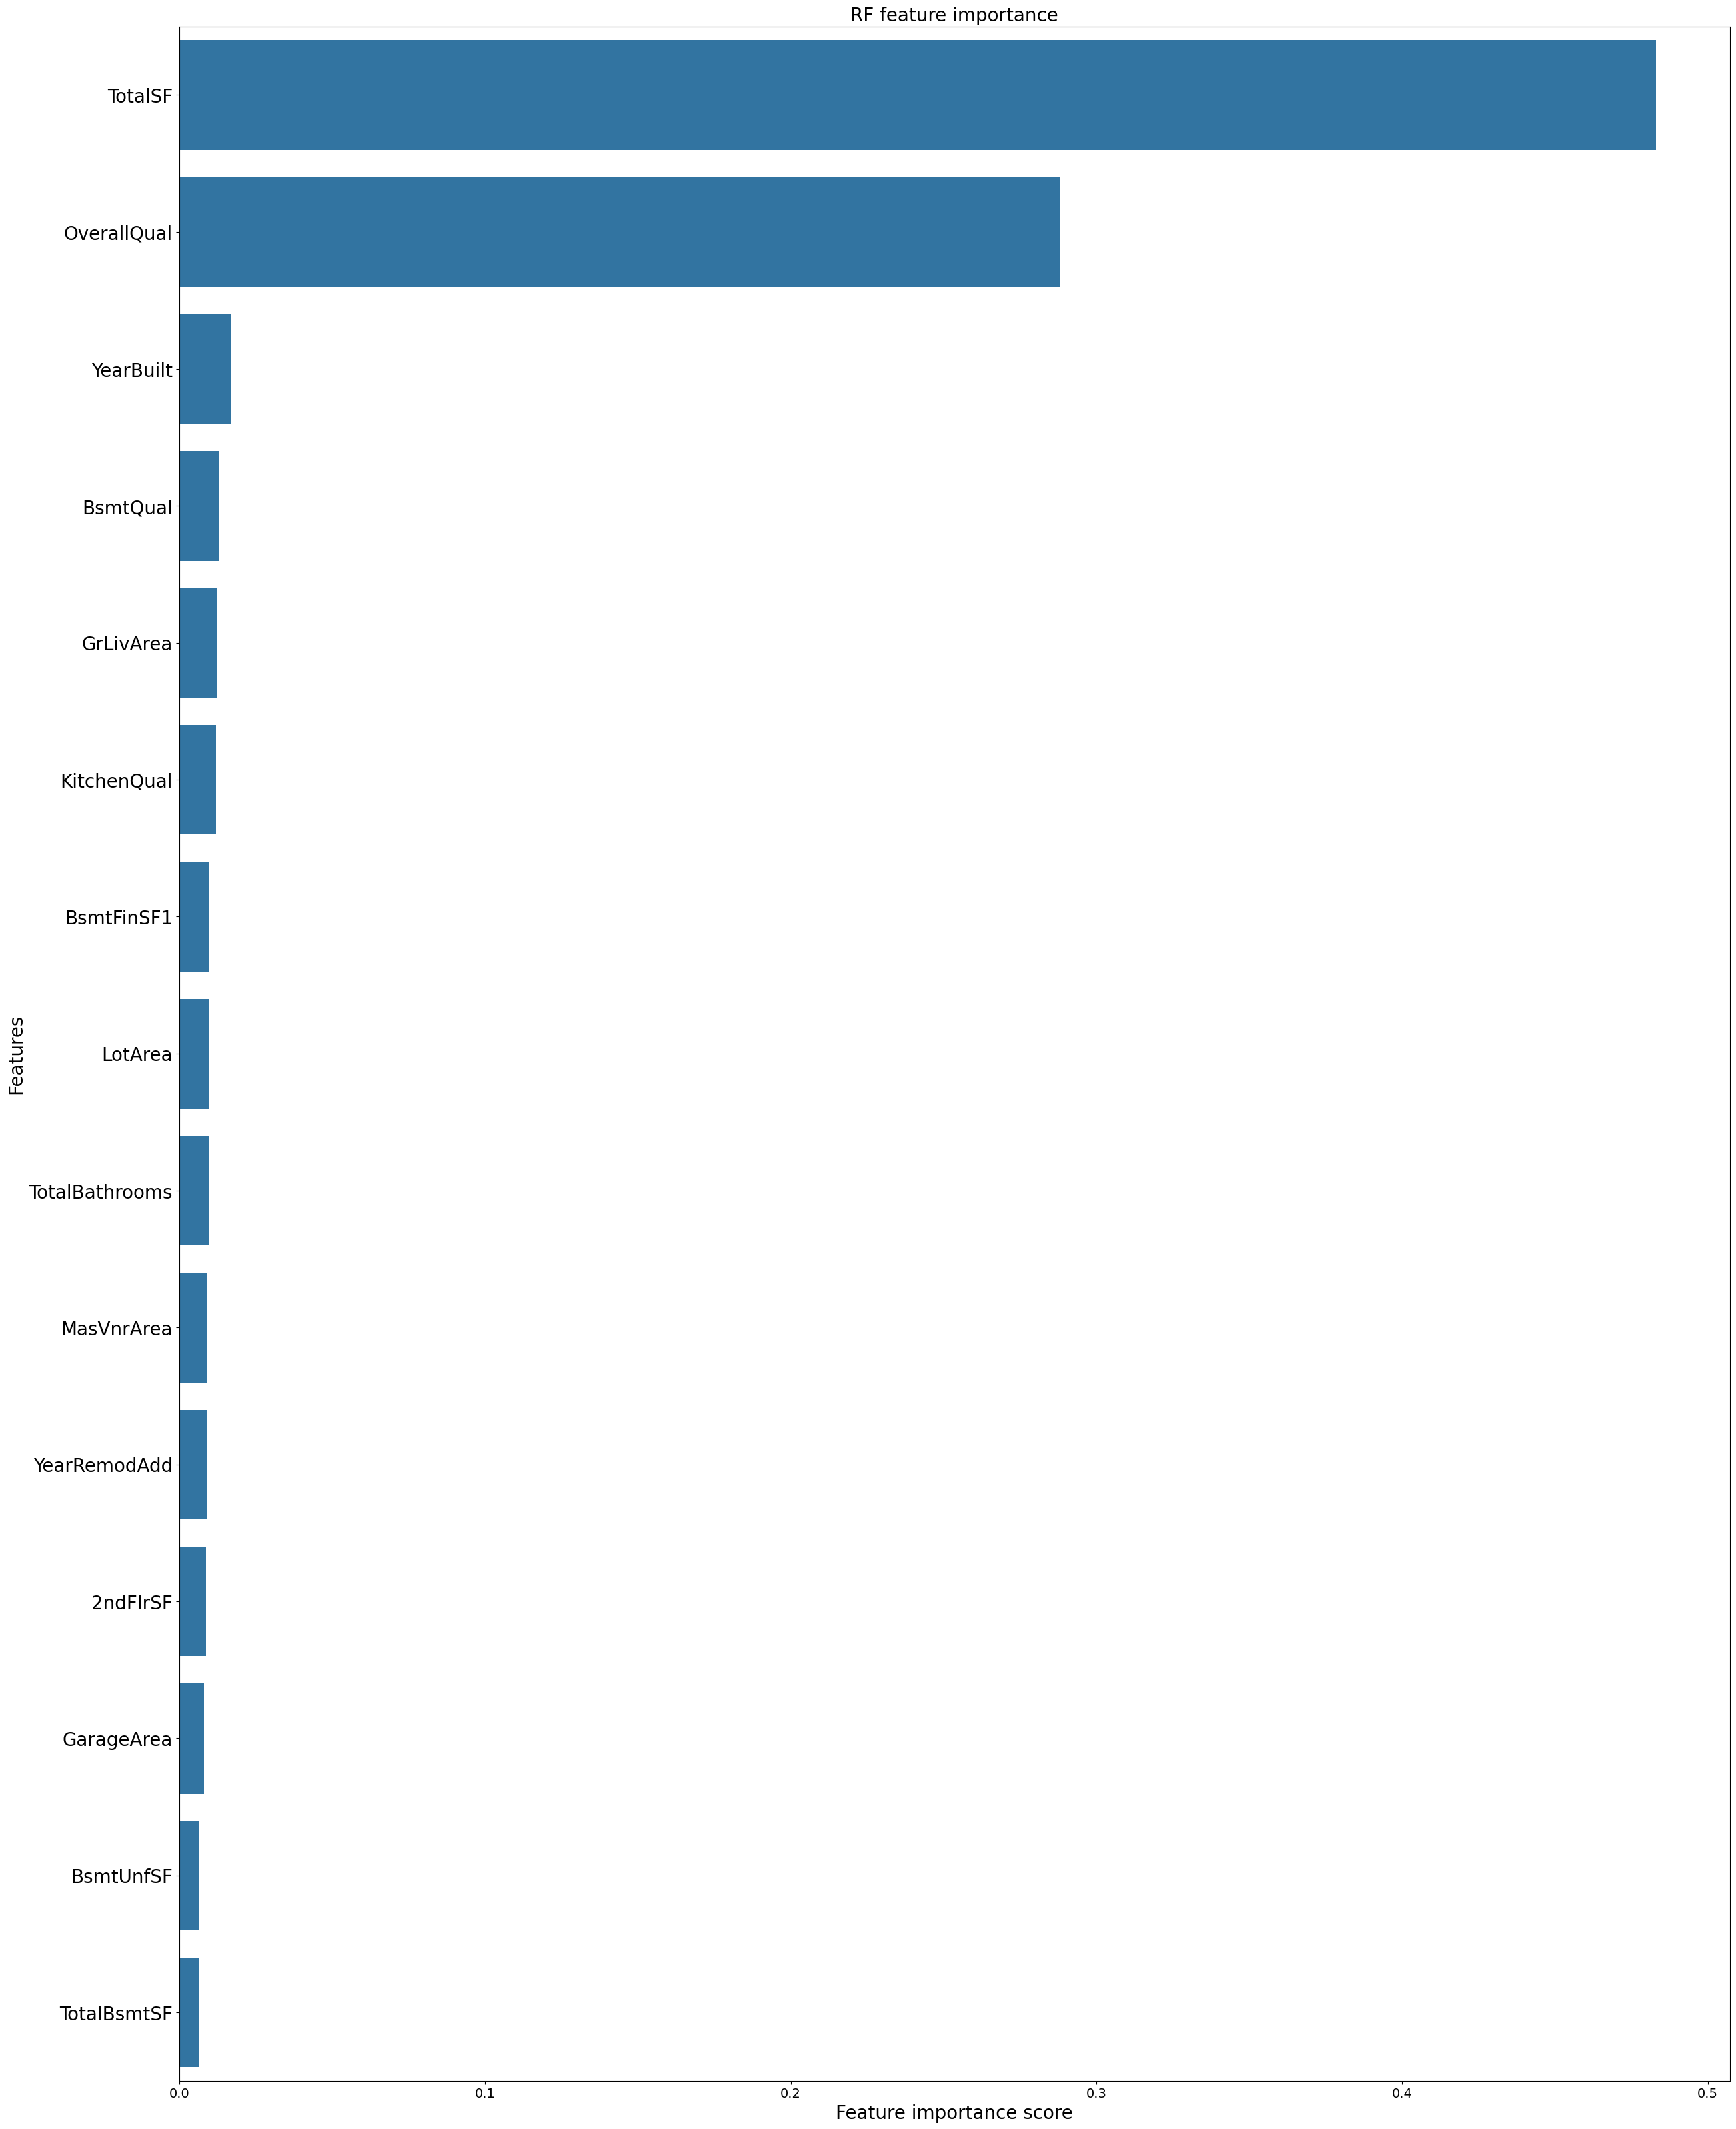

In [80]:
# Plot the rf_opt.feature_importances_ in a barplot 
top_feature_scores=feature_scores.head(15)
f, ax = plt.subplots(figsize=(30, 40))
ax = sns.barplot(x='Importance', y=top_feature_scores.index, data=top_feature_scores)
ax.set_title("RF feature importance", size = 20)
ax.set_yticklabels(feature_scores.index, size = 20)
ax.set_xlabel("Feature importance score", size = 20)
ax.set_ylabel("Features", size = 20)
ax.tick_params(axis='x', labelsize=14)
plt.show()

In [81]:
#Save the most important feature names to use for the pipeline 
top_features=["TotalSF", "OverallQual","YearBuilt","BsmtQual","GrLivArea","KitchenQual","BsmtFinSF1","LotArea",
              "TotalBathrooms","MasVnrArea","YearRemodAdd","2ndFlrSF", "GarageArea","BsmtUnfSF","TotalBsmtSF"
]

Now, we will create new training and test sets retaining only the top 15 features to see if this improves our pipeline performance. 

In [82]:
#retain the 15 top features
opt_X_train = X_train[top_features]
opt_X_test = X_test[top_features]

#sanity check
print(opt_X_train.shape)
print(opt_X_test.shape)

(1168, 15)
(292, 15)


## Modeling and Evaluation Pipeline: Second Attempt

In [83]:
# fit, tune and evaluate the models with hyperparameters on the sets with only 15 features
fitted_models = {}

for name, pipe in pipeline.items():
    model = RandomizedSearchCV(pipe, hyperparameters[name], scoring='neg_root_mean_squared_error',cv=10, n_jobs=-1)
    model.fit(opt_X_train, y_train)
    pred = model.predict(opt_X_test)
    
    fitted_models[name] = model    
    reg_results = pd.concat([reg_results, evaluate_regression(pred, name, model)], ignore_index=True)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.171e+10, tolerance: 6.401e+08
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.920e+10, tolerance: 6.571e+08
  model = cd_fast.enet_coordinate_descent(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

In [84]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
reg_results

,Model,Best Params,RMSE,R2 Score,MAE
0,linear,{},54563.31,0.569,23583.39
1,linear,{},54563.31,0.569,23583.39
2,poly,{'polynomialfeatures__degree': 1},54563.31,0.569,23583.39
3,lasso,"{'lasso__max_iter': 1000, 'lasso__alpha': 1e-06}",55071.98,0.561,23873.59
4,ridge,{'ridge__alpha': 100.0},51374.02,0.618,22244.71
5,dtree,"{'decisiontreeregressor__min_samples_leaf': 5, 'decisiontreeregressor__max_depth': 5}",38942.72,0.780,23889.35
6,rf,"{'randomforestregressor__n_estimators': 115, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': None}",33654.66,0.836,17017.23
7,linear,{},49584.17,0.644,24635.89
8,poly,{'polynomialfeatures__degree': 1},49584.17,0.644,24635.89
9,lasso,"{'lasso__max_iter': 1000, 'lasso__alpha': 1.0}",49583.60,0.644,24635.26
